# fitting a SSC spectrum with sherpa

In [1]:
import sys
sys.path.append("../../")
import numpy as np
import astropy.units as u
from astropy.coordinates import Distance
from astropy.table import Table
from agnpy.spectra import LogParabola
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from sherpa.models import model
from sherpa import data
import matplotlib.pyplot as plt
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

### function to rebin the data 
There is a lot of overlapping X-ray data, let us define a function to rebin the spectral points.
We'll just perform the mean of the flux points in a bin weighted with their errors.

In [2]:
def rebin_sed(nu, nuFnu, nuFnu_err, nu_bins):
    """rebin the SED"""
    nu_bins_ctr = []
    nuFnu_binned = []
    nuFnu_err_binned = []
    for i in range(len(nu_bins) - 1):
        nu_min, nu_max = nu_bins[i], nu_bins[i + 1]
        # which points in this bin?
        condition = (nu_min <= nu) * (nu <= nu_max)
        # go to the next bin if there are no spectral points in this
        if not np.any(condition):
            continue
        else:
            y = nuFnu[condition]
            y_err = nuFnu_err[condition]
            y_new = np.sum(y / np.power(y_err, 2)) / np.sum(np.power(y_err, -2))
            y_err_new = 1 / np.sqrt(np.sum(np.power(y_err, -2)))
            nu_bins_ctr.append(np.sqrt(nu_min * nu_max))
            nuFnu_binned.append(y_new)
            nuFnu_err_binned.append(y_err_new)
    return (
        np.asarray(nu_bins_ctr),
        np.asarray(nuFnu_binned),
        np.asarray(nuFnu_err_binned),
    )

### sherpa wrapper of agnpy synchrotron

In [3]:
class LogParabolaSSC(model.RegriddableModel1D):
    """wrapper of agnpy.synchrotron"""
    
    def __init__(self, name="lp_synch"):
        self.k_e = model.Parameter(name, "k_e", 1e-11, min=1e-15, max=1e-3)
        self.p = model.Parameter(name, "p", 2.1, min=1.0, max=5.0)
        self.q = model.Parameter(name, "q", 0.1, min=-2.0, max=2.0)
        self.gamma_0 = model.Parameter(name, "gamma_0", 1e3, min=1e2, max=1e6) 
        self.gamma_min = model.Parameter(name, "gamma_min", 10, min=1, max=1e3)
        self.gamma_max = model.Parameter(name, "gamma_max", 1e5, min=1e4, max=1e9)
        self.z = model.Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = model.Parameter(name, "d_L", 1e27, min=1e25, max=1e33)
        self.delta_D = model.Parameter(name, "delta_D", 10, min=0, max=50)
        self.B = model.Parameter(name, "B", 2, min=0.001, max=10)
        self.R_b = model.Parameter(name, "R_b", 1e16, min=1e14, max=1e18)
        
        model.RegriddableModel1D.__init__(self, name,
                                          (self.k_e, self.p, self.q, self.gamma_0, self.gamma_min, self.gamma_max,
                                           self.z, self.d_L, self.delta_D, self.B, self.R_b))

    def calc(self, pars, x):
        """Evaluate the model"""
        (k_e, p, q, gamma_0, gamma_min, gamma_max,z, d_L, delta_D, B, R_b) = pars
        # add units
        k_e *= u.Unit("cm-3")
        d_L *= u.cm
        B *= u.G
        R_b *= u.cm
        x *= u.Hz
        
        sed_synch = Synchrotron.evaluate_sed_flux(
            x, z, d_L, delta_D, B, R_b, LogParabola, k_e, p, q, gamma_0, gamma_min, gamma_max
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            x, z, d_L, delta_D, B, R_b, LogParabola, k_e, p, q, gamma_0, gamma_min, gamma_max
        )
        return sed_synch + sed_ssc

### fitting with sherpa

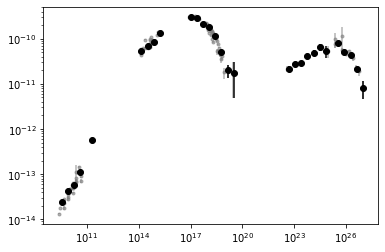

In [4]:
# read the 1D data
sed_table = Table.read("../../data/mwl_sed/Mrk421_2011.ecsv")
x = sed_table["nu"]
y = sed_table["nuFnu"] 
y_err = sed_table["nuFnu_err"]
# rebin
nu_bins = np.logspace(9, 30, 60)
x_new, y_new, y_err_new = rebin_sed(x, y, y_err, nu_bins)

plt.errorbar(x, y, yerr=y_err, ls="", marker=".", color="gray", alpha=0.6)
plt.errorbar(x_new, y_new, yerr=y_err_new, ls="", marker="o", color="k")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [5]:
# load them in a sherpa data object
sed = data.Data1D("sed", x_new, y_new, staterror=y_err_new)
print(sed)

name      = sed
x         = Float64[29]
y         = Float64[29]
staterror = Float64[29]
syserror  = None


In [6]:
# define the model
model = LogParabolaSSC()
# freeze some of the parameters
R_b = 1e15 * u.cm
z = 0.0308
d_L = Distance(z=z).to("cm")
# load the fixed parameters and freeze them
model.delta_D = 21
model.delta_D.freeze()
model.z = z
model.z.freeze()
model.d_L = d_L.cgs.value
model.d_L.freeze()
model.R_b = R_b.cgs.value
model.R_b.freeze()
model.gamma_0 = 5e4
#model.gamma_0.freeze()
model.gamma_min = 10
model.gamma_min.freeze()
model.gamma_max = 1e8
model.gamma_max.freeze()
print(model)

lp_synch
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   lp_synch.k_e thawed        1e-11        1e-15        0.001           
   lp_synch.p   thawed          2.1            1            5           
   lp_synch.q   thawed          0.1           -2            2           
   lp_synch.gamma_0 thawed        50000          100        1e+06           
   lp_synch.gamma_min frozen           10            1         1000           
   lp_synch.gamma_max frozen        1e+08        10000        1e+09           
   lp_synch.z   frozen       0.0308         0.01            1           
   lp_synch.d_L frozen  4.30448e+26        1e+25        1e+33           
   lp_synch.delta_D frozen           21            0           50           
   lp_synch.B   thawed            2        0.001           10           
   lp_synch.R_b frozen        1e+15        1e+14        1e+18           


In [7]:
# fit!
fitter = Fit(sed, model, stat=Chi2(), method=LevMar())
min_x = 1e12
max_x = 1e30
sed.notice(min_x, max_x)
print(fitter)
res = fitter.fit()
print("\n** fit succesful?", res.succeeded)
print(res.format())

data      = sed
model     = lp_synch
stat      = Chi2
method    = LevMar
estmethod = Covariance

** fit succesful? True
Method                = levmar
Statistic             = chi2
Initial fit statistic = 4.25944e+06
Final fit statistic   = 39533.4 at function evaluation 348
Data points           = 24
Degrees of freedom    = 19
Probability [Q-value] = 0
Reduced statistic     = 2080.7
Change in statistic   = 4.21991e+06
   lp_synch.k_e   2.12941e-09  +/- 1.03627e-12 
   lp_synch.p     4.36869      +/- 0           
   lp_synch.q     0.603953     +/- 0           
   lp_synch.gamma_0   235376       +/- 0           
   lp_synch.B     3.21303      +/- 0           


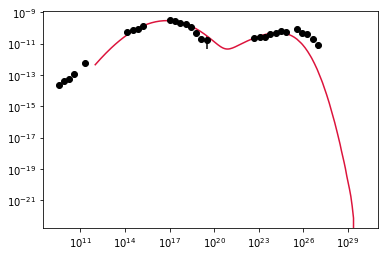

In [8]:
# plot the results
x = np.logspace(np.log10(min_x), np.log10(max_x), 200)
plt.errorbar(sed.x, sed.y, yerr=sed.staterror, marker="o", ls="", color="k")
plt.plot(x, model(x), ls="-", color="crimson")
plt.xscale("log")
plt.yscale("log")
plt.show()